# Music Recommender

## Functions for Spotipy

#### Actions
If song not in scraped top 100 dataframe...
1. get songs and artists from spotipy playlist and conduct same check
    1. fetch songs, artists, audiofeatures
    2. make dataframe
    3. check
2. if song in spotify playlist, recommend another song from the playlist
    1. get random song
    2. check if its the same song as the requested one
        1. if yes, get different random song
        2. else, recommend song
3. if song not in playlist, submit song to spotify for audio features

In [1]:
# libraries
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import getpass

# LOGIN
client_id = str(getpass.getpass('client_id?'))
client_secret = str(getpass.getpass('client_secret?'))

sp=spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id = client_id, client_secret= client_secret))


# formats the dataframe - lowercases and removes special characters and spaces from df
def format_df(df):
    df_lower = df.applymap(lambda s: s.lower() if type(s) == str else s)
    formatter = lambda s: ''.join(e for e in s if e.isalnum())
    df_clean = df_lower.applymap(formatter)
    return df



# function which handles more than 100 results
def get_playlist_tracks(user_id, playlist_id):
    
    # LOGIN
    #client_id = str(getpass.getpass('client_id?'))
    #client_secret = str(getpass.getpass('client_secret?'))
    client_id = '656c9257e8044fe98858ea5f578096bd'
    client_secret = '9b459f6afdf244168d86bac6cce0a90e'
    sp=spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id = client_id, client_secret= client_secret))
    
    # Query Spotify
    print('Fetching songs from Spotify...')
    results = sp.user_playlist_tracks(user_id, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks



# gets songs from chosen spotify playlist
def fetch_hot_songs_spotify():
        
    # specify playlists
    #user_id = 'maka_97'
    #playlist_id = '6mtYuOxzl58vSGnEDtZ9uB'
    user_id = '12174441449'
    playlist_id = '1T2VEWeXUzUzZ6piswWBjZ'
    
    # get songs from playlist
    playlist = get_playlist_tracks(user_id, playlist_id)
     
    # append songs and artists to lists
    song_ids = [r["track"]["id"] for r in playlist]
    songs = [r["track"]["name"] for r in playlist]
    artists = [r["track"]["artists"][0]['name'] for r in playlist]
    # write to DataFrame
    songs_df = pd.DataFrame({'song_ids':song_ids, 'songs':songs, 'artists':artists})
    
    # break song_ids into chunks of 100
    blocks = [song_ids[x:x+100] for x in range(0, len(song_ids), 100)]
    
    # get audio features for fetched Spotify songs
    print('Fetching audio features...')
    # submit blocks to spotify and add results to list
    feats = []
    for x in tqdm(range(len(blocks))):
        feats.append(sp.audio_features(tracks= blocks[x])) # returns list with blocks of dicts
    
    # add each dict in each block to new list
    feat_dicts = []
    for block in feats:
        for feat_dict in block:
            feat_dicts.append(feat_dict)
     
    feats_df = pd.DataFrame(feat_dicts)
    
    # join dataframes 
    df = pd.concat([songs_df, feats_df], axis=1)
    
    # export to csv
    df.to_csv('TopSongs_Spotify.csv', index=False) 
    
    # write timestamp to txt file
    timestamp= datetime.today().strftime('%Y-%m-%d')
    with open('last_scrape_spotify.txt', 'w') as f:
        f.write(timestamp)
            
    print('Fetch completed!\n')
    return df



client_id?········
client_secret?········


In [2]:
# import tools
from bs4 import BeautifulSoup
import pandas as pd
import requests
from tqdm.notebook import tqdm
from datetime import datetime
import random
from IPython.display import clear_output
from datetime import datetime

### Functions for search

In [2]:
   
# displays exit message
def say_goodbye():
    print('Thanks for using BEETz! Come back soon!')
    return



# checks for last scrape by reading txt file in which last date was stored
def check_last_scrape():
    with open('last_scrape.txt', 'r') as f:
        date = f.read()
    return date
        
    
    
# random excitement
def exclaim():
    exclamations=['SOO hot right now!', 'So hot its stolen!', 'Sizzzzzling!']
    exclamation = random.choice(exclamations)
    print('\n', exclamation)

    
    
# scrapes songs from online billboard, writes to csv, returns as df and records timestamp in txt file
def fetch_hot_songs():
    print('Fetching hot songs and artists from the web...')
    
    url = "https://www.billboard.com/charts/hot-100/"
    response = requests.get(url)
    website_data = response.text
    soup = BeautifulSoup(website_data, "html.parser")
    
    # append songs and artists to lists
    songs = []
    artists = []
    for i in tqdm(range(100)):
        songs.append(soup.select('h3.c-title.a-no-trucate')[i].get_text(strip=True))
        artists.append(soup.select('span.c-label.a-no-trucate')[i].get_text(strip=True))
    
    # write to DataFrame
    df_dirty = pd.DataFrame({'songs':songs, 'artists':artists})
    df.to_csv('TopSongs.csv', index=False) 
    
    # write timestamp to txt file
    timestamp= datetime.today().strftime('%Y-%m-%d')
    with open('last_scrape.txt', 'w') as f:
        f.write(timestamp)
            
    print('Fetch completed!\n')
    return df
    
    
    
# gets random song from scraped billboard and checks if identical with requested song
def get_random_song(x, df):
    # takes sample from unclean dataframe
    sample = df.sample()
    rec_song = str(sample.iloc[0, 0])
    rec_artist = str(sample.iloc[0, 1])
    # clean song and check to make sure its not the same song as requested
    lower_song = rec_song.lower()
    song_cleaned = ''.join(e for e in lower_song if e.isalnum())
    if x in song_cleaned:
        get_random_song(x, df_clean, df)
    else:
        print(f'BEETz recommends {rec_song} by {rec_artist}!')
        print('Go again?')
    
        

        
# Based on run_search, asks user to enter song, formats and checks to see if song is in 'hot' songs
def song_search(df_clean, df):
    song = input('Please enter the title of a song you enjoy: \n').lower()
    # remove spaces and special characters
    song_cleaned = ''.join(e for e in song if e.isalnum())
    
    # check if song title is in top hits
    if df_clean['songs'].str.contains(song_cleaned).any():
        exclaim()
        return song_cleaned
    # if not, offer another search
    else:
        print('Your song doesn\'t seem to be very popular...try again? ')
        #run_search(df_clean, df)
        
        '''ENTER CODE FOR SPOTIPY HERE''' 
        df = fetch_hot_songs_spotify()
    
# Based on run_search, asks user to enter artist, formats and checks if artist is in 'hot' artists
def artist_search(df_clean, df):
    artist = input('Please enter the name of an artist you enjoy: \n').lower()
    # remove spaces and special characters
    artist_cleaned = ''.join(e for e in artist if e.isalnum())
    
    # check if artist is in top artists
    if df_clean['artists'].str.contains(artist_cleaned).any():
        exclaim()
        return '-'
    # if not, offer another search
    else:
        print('Your artist doesn\'t seem to be very popular...try again? ')
        run_search(df_clean, df)
            

            
# gets user search preference and executes search accordingly
def run_search(df_clean, df):    
    response = input('''
    Enter 1 to search by song.
    Enter 2 to search by artist. 
    Enter 3 to exit.\n\n''')  
    if response == '1':
        x = song_search(df_clean, df)
    elif response == '2':
        x = artist_search(df_clean, df)
    elif response == '3':
        say_goodbye()
        return
    else:
        print('Hm...that didn\'t work. Please try again.')
        run_search(df_clean, df)
    
    # Recommends random song after checking that it doesn't match searched song
    get_random_song(x, df)
    
    run_search(df_clean, df)
        

## Primary function

In [3]:
# the MOTHER function

def beetz():
    
    print('''
     ____  ______ ______ _______  
 |  _ \|  ____|  ____|__   __| 
 | |_) | |__  | |__     | |____
 |  _ <|  __| |  __|    | |_  /
 | |_) | |____| |____   | |/ / 
 |____/|______|______|  |_/___|
 ''')
        
    print('HELLO! Welcome to the BEETz song recommender!')
    print('BEETz will recommend a song related to the song or artist you enter.')
    
    
    # checks for last scrape - if not from today, launches new scrape
    if check_last_scrape() == datetime.today().strftime('%Y-%m-%d'):
        print('We have an up-to-date list of HOT songs from today on file!')
        df = pd.read_csv('TopSongs.csv', index_col=False)
    else:
        print('We will fetch an up-to-date list of HOT songs from today!')
        df = fetch_hot_songs()
    
    # lowercase and remove special characters and spaces from df
    df_lower = df.applymap(lambda s: s.lower() if type(s) == str else s)
    formatter = lambda s: ''.join(e for e in s if e.isalnum())
    df_clean = df_lower.applymap(formatter)
    
    # gets user search preference and executes search accordingly
    run_search(df_clean, df)
    

In [4]:
beetz()


     ____  ______ ______ _______  
 |  _ \|  ____|  ____|__   __| 
 | |_) | |__  | |__     | |____
 |  _ <|  __| |  __|    | |_  /
 | |_) | |____| |____   | |/ / 
 |____/|______|______|  |_/___|
 
HELLO! Welcome to the BEETz song recommender!
BEETz will recommend a song related to the song or artist you enter.
We have an up-to-date list of HOT songs from today on file!

    Enter 1 to search by song.
    Enter 2 to search by artist. 
    Enter 3 to exit.

3
Thanks for using BEETz! Come back soon!


In [16]:
# fetch hot songs from spotify
df= fetch_hot_songs_spotify()


Fetching songs from Spotify...
Fetching audio features...


  0%|          | 0/19 [00:00<?, ?it/s]

Fetch completed!



In [17]:
df.head()

,song_ids,songs,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,2I6mf3RFLj1c0k5OpX5sKg,Guns and Dogs,Portugal. The Man,0.614,0.670,10,-6.616,1,0.0329,0.36000,...,0.1080,0.578,80.022,audio_features,2I6mf3RFLj1c0k5OpX5sKg,spotify:track:2I6mf3RFLj1c0k5OpX5sKg,https://api.spotify.com/v1/tracks/2I6mf3RFLj1c...,https://api.spotify.com/v1/audio-analysis/2I6m...,164520,4
1,6QgjcU0zLnzq5OrUoSZ3OK,Feel It Still,Portugal. The Man,0.801,0.795,1,-5.115,0,0.0504,0.04170,...,0.0717,0.754,79.028,audio_features,6QgjcU0zLnzq5OrUoSZ3OK,spotify:track:6QgjcU0zLnzq5OrUoSZ3OK,https://api.spotify.com/v1/tracks/6QgjcU0zLnzq...,https://api.spotify.com/v1/audio-analysis/6Qgj...,163253,4
2,4SNtyKNyYJ8ERT7YLlnFBr,So Young,Portugal. The Man,0.671,0.445,4,-7.842,0,0.0291,0.34800,...,0.1550,0.811,75.996,audio_features,4SNtyKNyYJ8ERT7YLlnFBr,spotify:track:4SNtyKNyYJ8ERT7YLlnFBr,https://api.spotify.com/v1/tracks/4SNtyKNyYJ8E...,https://api.spotify.com/v1/audio-analysis/4SNt...,246480,4
3,0NBAXi7pWtoiLo7oomWBKw,Forever & Ever More,Nothing But Thieves,0.289,0.841,8,-4.330,1,0.1460,0.00582,...,0.2670,0.399,183.170,audio_features,0NBAXi7pWtoiLo7oomWBKw,spotify:track:0NBAXi7pWtoiLo7oomWBKw,https://api.spotify.com/v1/tracks/0NBAXi7pWtoi...,https://api.spotify.com/v1/audio-analysis/0NBA...,208134,3
4,3meXdlcyYTgukuOfX6VyhJ,Amsterdam,Nothing But Thieves,0.513,0.932,10,-5.016,1,0.1720,0.00456,...,0.2450,0.665,168.062,audio_features,3meXdlcyYTgukuOfX6VyhJ,spotify:track:3meXdlcyYTgukuOfX6VyhJ,https://api.spotify.com/v1/tracks/3meXdlcyYTgu...,https://api.spotify.com/v1/audio-analysis/3meX...,272240,4


In [36]:
new_df= df.copy()
new_df.index = new_df['song_ids']
new_df.rename_axis(None, inplace=True)
trimmed_df = new_df.drop(['track_href', 'uri', 'analysis_url', 'id', 'song_ids', 'type', 'songs', 'artists'], axis=1 )
trimmed_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
2I6mf3RFLj1c0k5OpX5sKg,0.614,0.670,10,-6.616,1,0.0329,0.36000,0.085600,0.1080,0.578,80.022,164520,4
6QgjcU0zLnzq5OrUoSZ3OK,0.801,0.795,1,-5.115,0,0.0504,0.04170,0.000113,0.0717,0.754,79.028,163253,4
4SNtyKNyYJ8ERT7YLlnFBr,0.671,0.445,4,-7.842,0,0.0291,0.34800,0.000059,0.1550,0.811,75.996,246480,4
0NBAXi7pWtoiLo7oomWBKw,0.289,0.841,8,-4.330,1,0.1460,0.00582,0.007710,0.2670,0.399,183.170,208134,3
3meXdlcyYTgukuOfX6VyhJ,0.513,0.932,10,-5.016,1,0.1720,0.00456,0.000025,0.2450,0.665,168.062,272240,4


In [37]:
columns_list = trimmed_df.columns.to_list()
columns_list

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature']

### Apply clustering

In [20]:
import numpy as np
import plotly
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn import datasets

In [21]:
# Apply clustering 
kmeans = KMeans(n_clusters = 24)
cluster = kmeans.fit(trimmed_df)

In [22]:
trimmed_df['cluster'] = cluster.labels_

In [23]:
trimmed_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
2I6mf3RFLj1c0k5OpX5sKg,0.614,0.670,10,-6.616,1,0.0329,0.36000,0.085600,0.1080,0.578,80.022,164520,4,0
6QgjcU0zLnzq5OrUoSZ3OK,0.801,0.795,1,-5.115,0,0.0504,0.04170,0.000113,0.0717,0.754,79.028,163253,4,0
4SNtyKNyYJ8ERT7YLlnFBr,0.671,0.445,4,-7.842,0,0.0291,0.34800,0.000059,0.1550,0.811,75.996,246480,4,19
0NBAXi7pWtoiLo7oomWBKw,0.289,0.841,8,-4.330,1,0.1460,0.00582,0.007710,0.2670,0.399,183.170,208134,3,12
3meXdlcyYTgukuOfX6VyhJ,0.513,0.932,10,-5.016,1,0.1720,0.00456,0.000025,0.2450,0.665,168.062,272240,4,8


In [25]:
trimmed_df['cluster'].value_counts()

17    254
4     233
19    224
12    197
9     194
8     168
1     148
0     128
14     92
7      64
10     58
5      38
13     26
16     13
3      12
18      5
11      4
15      2
2       1
6       1
Name: cluster, dtype: int64

## Finding the optimal k

In [ ]:
# number of initialisations is 10
# looking for small itertia / distortion score

In [27]:
kmeans.inertia_

89050708324.14264

In [31]:
K= range(10, 30)
inertia = []
for k in K:
    kmeans = KMeans(n_clusters= k, random_state = 0)
    kmeans.fit(trimmed_df)
    inertia.append(kmeans.inertia_)
inertia

[344875830467.06775,
 284502665619.7701,
 243291972414.4756,
 208987817678.88666,
 178540019732.5985,
 159021662940.58652,
 143149334402.35565,
 127321955667.36008,
 113984703855.02225,
 101046909564.47247,
 90950541842.24931,
 79750953298.07318,
 71206763236.61792,
 64682256523.9576,
 58732007502.91765,
 55755371512.622765,
 49460241840.23164,
 45455769350.74303,
 41114573552.15818,
 37765855577.046616]

([<matplotlib.axis.XTick at 0x1999c2a2f40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

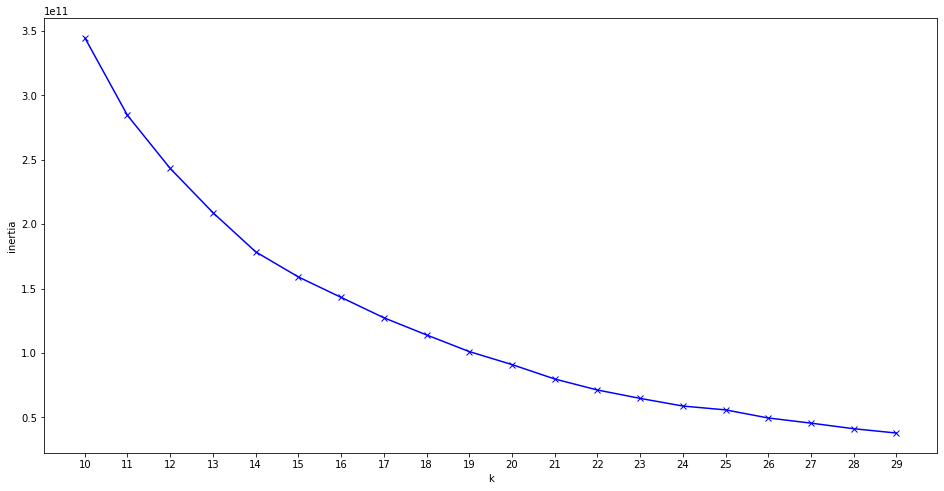

In [33]:
# Plot elbow plot
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1,1.0))

In [38]:
from sklearn.preprocessing import StandardScaler

In [40]:
feats_scaled=StandardScaler().fit_transform(trimmed_df)

In [41]:
feats_scaled_df = pd.DataFrame(feats_scaled, columns = columns_list) 

In [42]:
feats_scaled_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.458653,-0.735673,1.258769,-0.281467,0.860341,-0.707214,1.599357,0.050395,-0.638446,0.262260,-1.398947,-1.011149,0.137908
1,1.585788,0.009430,-1.225269,0.281832,-1.162330,-0.502342,-0.259112,-0.383795,-0.843952,1.063057,-1.431764,-1.027379,0.137908
2,0.802218,-2.076859,-0.397256,-0.741563,-1.162330,-0.751701,1.529292,-0.384068,-0.372363,1.322406,-1.531864,0.038761,0.137908
3,-1.500271,0.283628,0.706761,0.576428,0.860341,0.616850,-0.468606,-0.345210,0.261707,-0.552186,2.006455,-0.452452,-3.583614
4,-0.150120,0.826063,1.258769,0.318985,0.860341,0.921233,-0.475963,-0.384243,0.137157,0.658109,1.507669,0.368747,0.137908
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,0.428516,-0.181317,-1.501273,-1.534534,-1.162330,0.605143,0.355707,-0.356282,-0.774318,1.126757,1.802127,0.937000,0.137908
1858,-1.813698,0.909514,1.258769,0.679255,-1.162330,0.406124,-0.501717,-0.380585,-0.304427,-1.075434,1.217139,-0.481954,0.137908
1859,-0.385191,0.337275,-0.673261,0.535522,-1.162330,-0.381759,-0.502053,0.341931,0.023931,0.234960,1.118260,0.044564,0.137908
1860,-1.078349,-1.868230,0.982765,-2.223176,0.860341,-0.107815,2.539393,-0.362529,-0.242152,-0.752386,-0.069676,2.184018,0.137908


## Scaled

In [48]:
K= range(10, 30)
inertia = []
for k in K:
    kmeans = KMeans(n_clusters= k, random_state = 0)
    kmeans.fit(feats_scaled_df)
    inertia.append(kmeans.inertia_)
inertia

[13545.539240428783,
 13053.151377929998,
 12650.455374435483,
 12375.024565749449,
 12093.813338500477,
 11795.004893259338,
 11635.48371990622,
 11418.947734671498,
 11116.037673400677,
 11024.767627884368,
 10854.612394042226,
 10746.389550607772,
 10619.749080800488,
 10417.251161787199,
 10318.355154074088,
 10157.728029881679,
 10125.963636562186,
 9938.211294331519,
 9884.126258650867,
 9769.313474576116]

([<matplotlib.axis.XTick at 0x1999c11d1f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

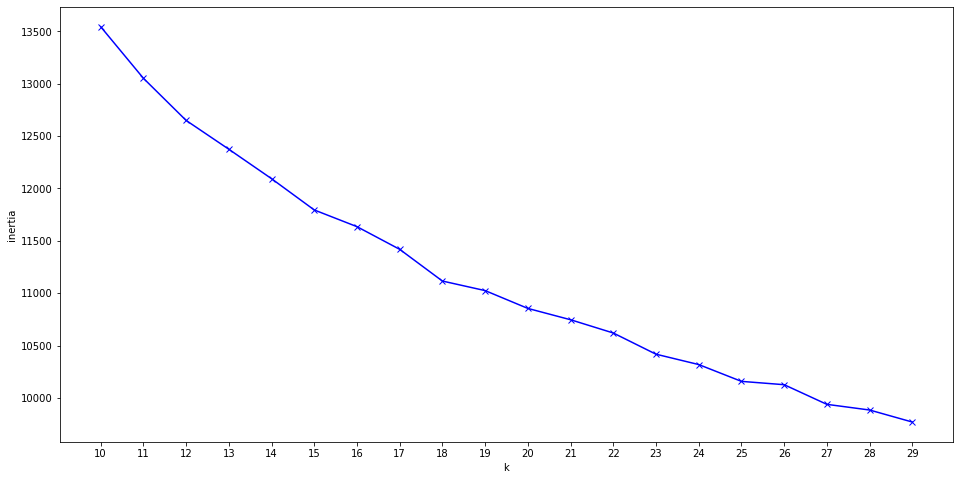

In [49]:
# Plot elbow plot
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1,1.0))

In [46]:
from sklearn.metrics import silhouette_score
K2 = range(10, 30)
sil = []

for k in K2:
  kmeans = KMeans(n_clusters = k).fit(feats_scaled_df)
  labels = kmeans.labels_
  sil.append(silhouette_score(feats_scaled_df, labels, metric = 'euclidean'))
sil

[0.1113647664374073,
 0.10415870566927182,
 0.10792401392734488,
 0.10434756106547174,
 0.11176055995856979,
 0.10872258023417371,
 0.11217502702931172,
 0.1158903262923121,
 0.10880998688824974,
 0.10856354927344401,
 0.10850743915609119,
 0.11633267461700059,
 0.11026966688016468,
 0.11074882353546958,
 0.1058305733144686,
 0.10403052456760062,
 0.10604257022919768,
 0.11040758486684257,
 0.1101334974081452,
 0.11242100061377329]

([<matplotlib.axis.XTick at 0x1999a2df0d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

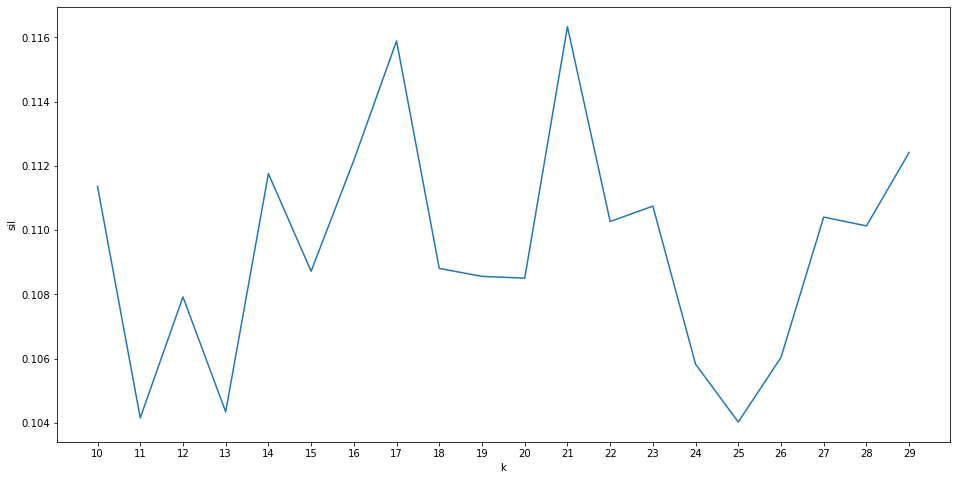

In [47]:
# Plot silhouette
plt.figure(figsize=(16,8))
plt.plot(K2, sil, label='sil')
plt.xlabel('k')
plt.ylabel('sil')
plt.xticks(np.arange(min(K2), max(K2)+1,1.0))

### Note:
- after scaling, 21 appears to be a good cluster size